<a href="https://colab.research.google.com/github/fblondiaux/LGBIO2072-2020/blob/TP2-Draft/LGBIO2072_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 - Firing Rate
__Authors:__ Antoine de Comite and Florence Blondiaux

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy

In [ ]:
#@title Useful libraries and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def rand_syn(t,sigma = 0.1, imean = 25e-11):
    dt = t[1]-t[0]
    return imean * (1 + 0.1 * (np.sqrt(np.max(t)/dt)) * np.random.normal(0,sigma,len(t)))

def step_current(t,sigma = 0.1, imean = 25e-11):
    """
    Returns a step current, with step mean =  25e-11
    """
    i = np.zeros_like(t)
    i[int(len(t)/2):] = 1 #step
    i = i+np.random.normal(0,sigma,len(t)) 
    return imean * i

def LIF(input_current,t,  tau= 20e-3 , urest= -60e-3 , r= 100e6, ureset = -70e-3 \
               ,theta = -50e-3, t_ref = 10e-3 ): 
    """
    Authors : Antoine de Comite and Florence Blondiaux
    Simulate the LIF model in response to an external input current
    Args:
      input_current   : Vector containing the input current [A].
      t               : Vector containing the discretized time points [s]
      tau             : Membrane time constant. Default value: 20e-3 [s]
      urest           : Leak potential. Default value: -60e-3 [V]
      r               : Leak resistance. Default value: 100e6 [Ohm]
      ureset          : Reset potential. Default value: -70e-3[V]
      theta           : Firing threashold. Default value: -50e-3 [V]
      t_ref           : Refractory period. Default value: 10e-3 [S]
    Returns:
      u               : membrane potential [V]
      ts              : spike times [s]
    """
    u = np.zeros_like(input_current)
    ts = []
    dt = t[1]-t[0]
    S = np.zeros_like(input_current)
    u[0]=urest
    t_wait = 0
    for step in range(0,len(input_current)-1):
        if u[step] > theta:
            u[step]= theta / 1.2
            u[step+1] = ureset
            t_wait = t_ref/dt
            ts.append((step+1)*dt)
        elif t_wait >0:
            u[step +1] = ureset
            t_wait -=1
        else:
            u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u, ts

def load_dataset():
  url = 'https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/ExtraContent/Output_Current.csv'
  df = pd.read_csv(url, error_bad_lines=False)
  S = df.to_numpy()
  return S, 1e-3
def plot_data(S):
  for i in range(len(S)):
    spike_times = S[i]
    plt.scatter(np.where(S[i,:]==1),i*np.ones_like(np.where(S[i,:]==1)),facecolor='skyblue',edgecolor = "white")
    plt.xlabel('Time [mS]')
    plt.ylabel('Neuron')
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()


---
## Raster plot

A *raster plot* represents spikes from multiple neurons by plotting dots at spike times from neuron `j` at plot height `j`, i.e. It can be useful to visualise the activity of several neurons at the same time.
```
plt.scatter(spike_times, j*np.ones_like(spike_times))
```

![spikes plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/spikes_plot.png)

## Exercise 1
Simulate the responses of 500 neurons to a random input current and create a rasterplot to compile their answers.

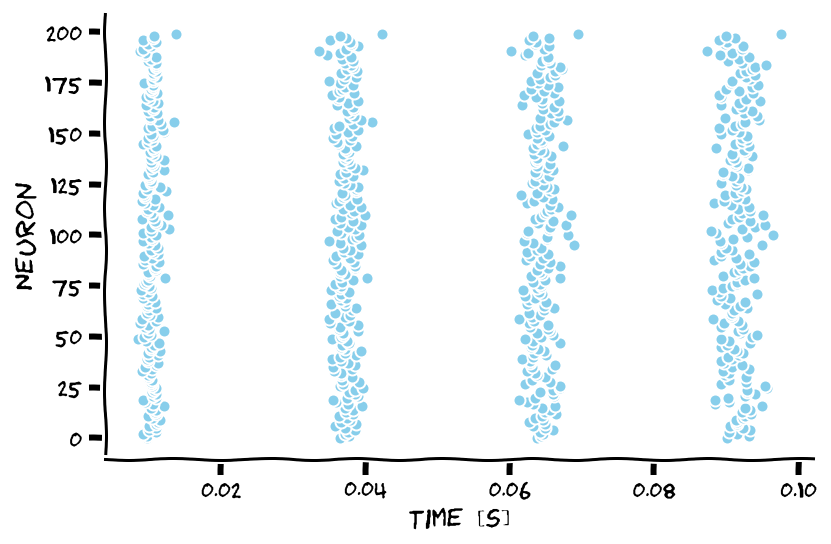

In [ ]:
def make_raster_plot(N,t_range,sigma=0.1):
    """Computes the answer of N neurons to a random synaptic input current
    And plot the results on a raster plot
    N : number of neurons
    t_range : the timings we are investigating for all the neurons
    sigma: Noise for the random current
    
    """
    dt = t_range[1]-t_range[0]
    neurons= {}
    for i in range(N):
        input_current = rand_syn(t_range,sigma)
        u,neurons[i] = LIF(input_current, t_range)

    for i in range(N):
        spike_times = neurons[i]
        plt.scatter(spike_times, i*np.ones_like(spike_times),facecolor='skyblue',edgecolor = "white")
    plt.xlabel('Time [S]')
    plt.ylabel('Neuron')
    plt.show()
        

t_max = 100e-3   # second
dt = .1e-3        # second
t_range = np.arange(0,t_max,dt)
with plt.xkcd():
  make_raster_plot(200,t_range,sigma=0.2)

In [ ]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    sigma=widgets.FloatSlider(0.8, min=0, max=2, step=0.25, layout=my_layout)

)

def raster_plot(sigma = 0.8):
    t_max = 150e-3   # second
    dt = 1e-3        # second
    step_end = int(t_max / dt) - 1
    t_range = np.linspace(0,dt*step_end,step_end)
    input_current = rand_syn(t_range,dt, sigma)
    
    make_raster_plot(200,t_range,sigma)



interactive(children=(FloatSlider(value=0.8, description='sigma', layout=Layout(width='450px'), max=2.0, step=…

---

# Local linearities

** Add an exercise where students have to implement different input and see that locally its linear even if we know that it is not in real life **

---
## Firing rate : Reiminder 

Spikes alone are not very informative, however, having closer look to the spikes train can bring very informative as looking at firing rate and spiking regularity. 

The firing rate can be approximated using a rectangle kernel. 
Let ${f_i}^n_{i=1}$ represent the firing times and $S(t) := \sum_i \delta(t-t_i)$ be the spike train.

The firing rate, $p(t)$, is defined as the convolution of the spike train with a
kernel function called $\kappa(t)$: $$ \rho(t):= \kappa(t) *  S(t) = \int \kappa(t) S(t-s)ds$$

The instantaneous firing rate depends on the choice of the kernel
function !

## Exercice 7

Compute the firing rate using a rectangular kernel $ \kappa(t)= (\Delta t)^{-1} 1_{0 \leq t \leq \Delta t} $. $\rho(t)$ will therefore be the spike count in a sliding window of side $\Delta t$.

Hint: use the convolve function from numpy


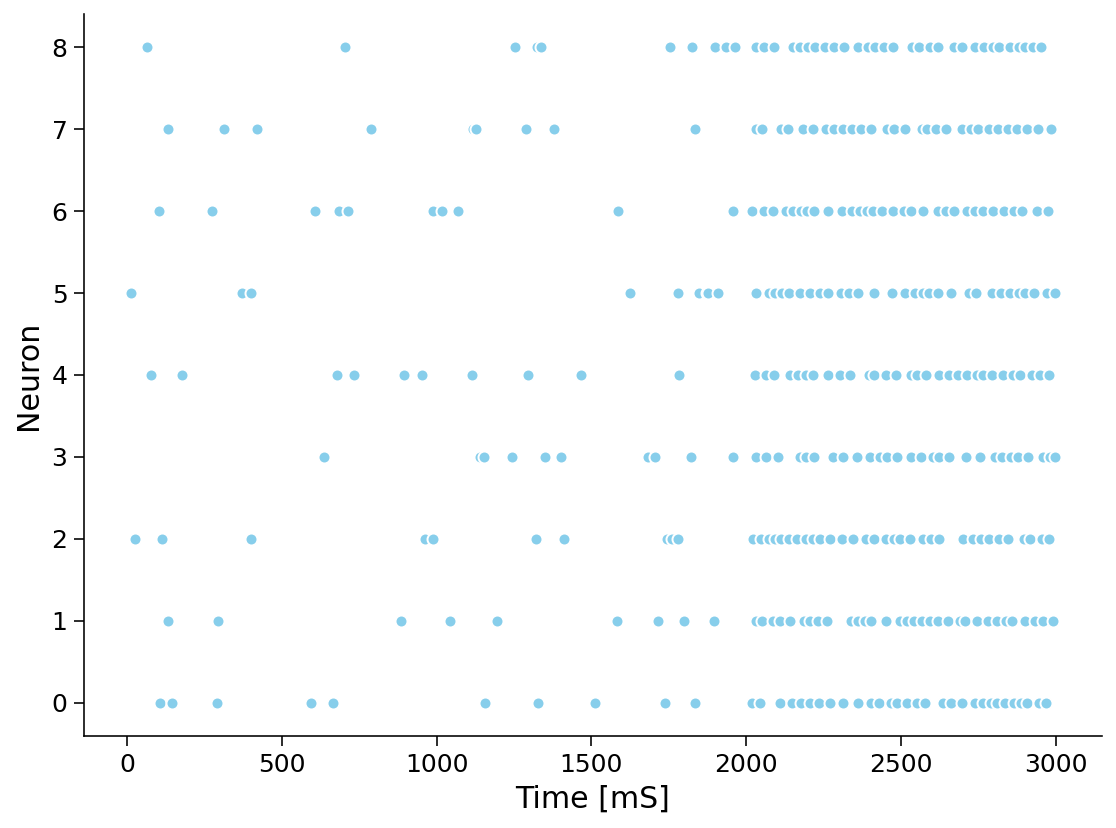

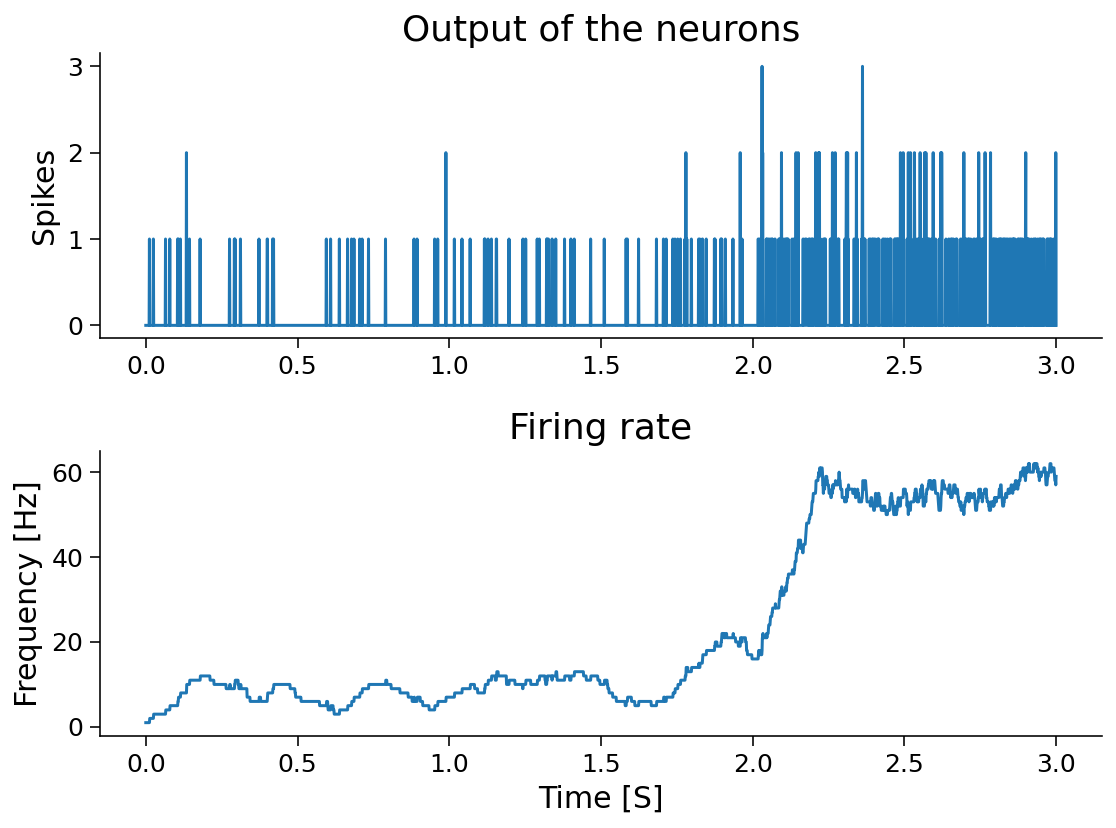

In [42]:
#Firing rate
""" 
Computes the firing rate of a neuron, needs in imput the spike train, and the kernel function. 
Output the firing rate."""
def firing_rate_rectKernel(S,dt = 1e-3, Dt = 0.2):
    k = np.zeros(len(S[0,:]))
    k[1:int(Dt/dt)] = 1 #Kernel 
    res = np.ones((10,6001)) # Il y à de manière évidente un problème quelque part, mais c'est vendredi et il est 
    # 4h, mon cerveau n'arrive plus à réfléchir --'
    for i in range(np.size(S[:,0])):
        res[i,:] = np.convolve(S[i,:], k) #A peu près sure que c'est dans les paramètres à donner à convovle : 'same, 'valid
    return np.sum(res,axis=0)




S, dt = load_dataset()
plot_data(S)



t_range = np.arange(0,3.001,1e-3)
fig, axs = plt.subplots(2)
axs[0].plot(t_range,np.sum(S,axis = 0))
axs[0].set(title = "Output of the neurons", ylabel = "Spikes")
axs[1].plot(t_range, firing_rate_rectKernel(S)[:3001]) #Je n'ai pas trouvé les bons paramètres pour la convolution, je suis obligée de supprimer le reste de l'output (que des 0s)
axs[1].set(title = "Firing rate", ylabel = "Frequency [Hz]", xlabel= "Time [S]")
plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Av firing rate')

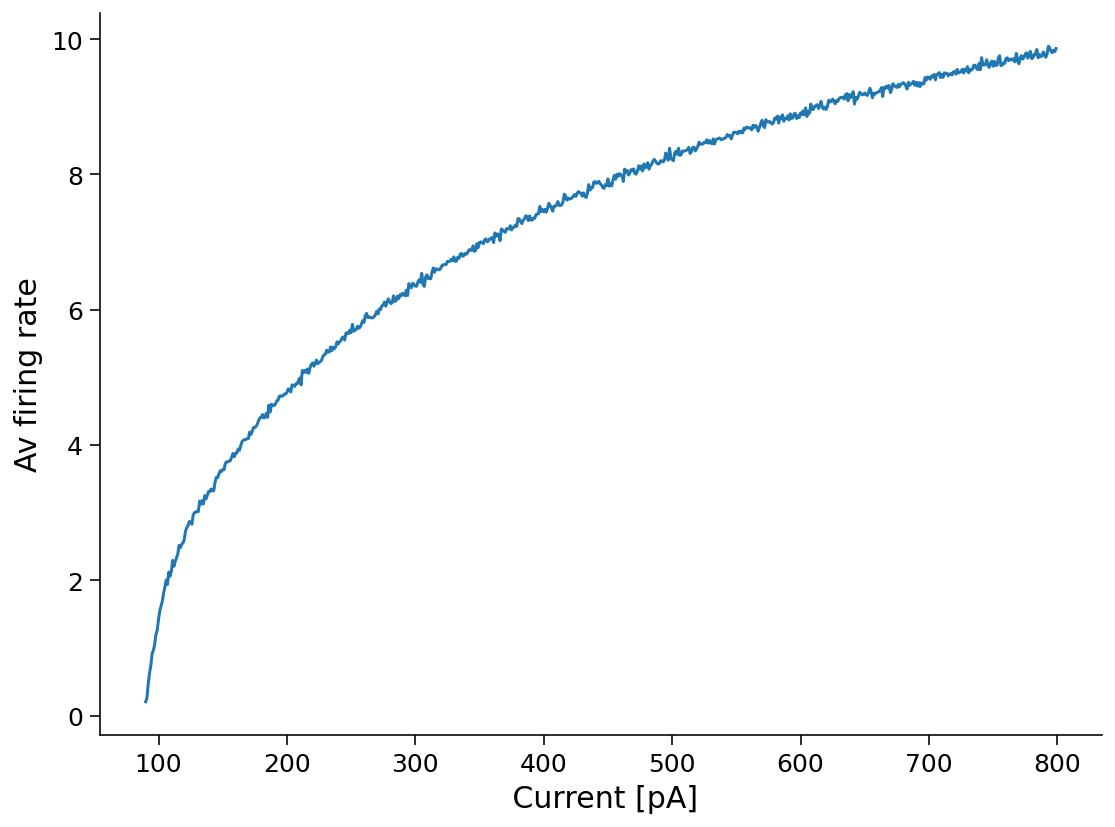

In [59]:
""" 
Computes the firing rate of a neuron, needs in imput the spike train, and the kernel function. 
Output the firing rate."""
def firing_rate_rectKernel(S,dt = 1e-3, Dt = 0.2):
    if sum(S) == 0:
      return S
    else:

      k = np.zeros(len(S))
      k[1:int(Dt/dt)] = 1 #Kernel 
      # 4h, mon cerveau n'arrive plus à réfléchir --'
      res = np.convolve(S, k) #A peu près sure que c'est dans les paramètres à donner à convovle : 'same, 'valid
      return res[:len(S)]





t_max = 1000e-3   # second
dt = 1e-3        # second
t_range = np.arange(0,t_max,dt)
imax = 800

spike_av = np.zeros(imax)
for i in range(imax):
    nb_spike = np.zeros(10)
    for j in range(10):
      input_current = rand_syn(t_range, sigma =0.1, imean = i*1e-12)
      u,ts = LIF(input_current, t_range)

      #From time spike, generates a vector of 1 and zeros
      s_index = [int(tsi/dt) for tsi in ts]
      S = np.zeros_like(t_range)
      S[s_index] = 1

      #firing rate
      nb_spike[j] = np.mean(firing_rate_rectKernel(ts))

    spike_av[i] = np.mean(nb_spike)
plt.plot(range(imax),spike_av)
plt.xlabel(" Current [pA]")
plt.ylabel("Av firing rate")

In [ ]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    Dt=widgets.FloatSlider(0.2, min=0, max=0.5, step=0.025, layout=my_layout)

)

def firingRate(Dt = 0.2):
        
    t_range = np.arange(0,3.001,1e-3)
    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,np.sum(S,axis = 0))
    axs[0].set(title = "Output of the neurons", ylabel = "Spikes")
    axs[1].plot(t_range, firing_rate_rectKernel(S,1e-3,Dt)[:3001])
    axs[1].set(title = "Firing rate", ylabel = "Frequency [Hz]", xlabel= "Time [S]")
    plt.show()

# Various kernels

Ex with a gaussian kernel, 

Exp kernel =  bonus

---
# ISI intervals and coefficient of variation

Spike regularity can be quantified as the **coefficient of variation (CV) of the inter-spike-interval (ISI)**:
\begin{align}
\text{CV}_{\text{ISI}} = \frac{std(\text{ISI})}{mean(\text{ISI})}
\end{align}

The inter-spike-interval is simply the time between two spikes. 

A Poisson train is an example of high irregularity, in which $\textbf{CV}_{\textbf{ISI}} \textbf{= 1}$. And for a clocklike (regular) process we have $\textbf{CV}_{\textbf{ISI}} \textbf{= 0}$ because of **std(ISI)=0**.

## Exercice 8
Compute the inter-spike interval distribution as well as the coefficient of variation of signals provided in S to assess the stochasticity of neuron's activity. Plot the ISI distribution with an histogram to visualize the spike regularity of the neuron. 

Hint: look at the function hist of the matplotlib library

In [ ]:
S,dt = load_dataset()
"This function plots the ISI distribution of the neuron spike train and returns the coefficient of variation"
def plot_ISI(spikeTrain, dt):
    ISI = np.diff((np.where(spikeTrain))[0]*dt)
    plt.hist(ISI,150)
    plt.xlabel('Time [S]')
    plt.title("Histogram of the ISI distribution")
    plt.show()
    return (np.std(ISI)/np.mean(ISI))
CV = plot_ISI(S[1,:],dt)
print("The coefficient of variaion of this neuron is", CV)

In [ ]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    neuron=widgets.IntSlider(0, min=0, max=9, step=1, layout=my_layout)

)

def firingRate(neuron = 0):
        
    S = np.genfromtxt('Output_Current.csv', delimiter=',') #TO UPLOAD ON GITHUB
    CV=plot_ISI(S[neuron,:],1e-3)
    print("The CV for neuron", neuron, "is :", CV)